# Poly Prep
Cascade Tuholske Feb 2021 - updated to use the GPWv4 input boundaries


In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
from rasterio import features
import rasterio
import rasterio.mask
import rioxarray as rio
from skimage.filters import rank
from rasterio.enums import Resampling
from whitebox import WhiteboxTools

In [2]:
# file paths 
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'

## Dissolve polygons for Mozambique, Zimbabwe & Malawai 

#### Make Admin 0

In [10]:
# polys in
zwe = gpd.read_file(DATA_PATH+'raw/GPWv4-boundaries/gwpv4_zwe_admin2.shp')[['geometry']]
mwi = gpd.read_file(DATA_PATH+'raw/GPWv4-boundaries/gwpv4_mwi_admin3.shp')[['geometry']]
moz = gpd.read_file(DATA_PATH+'raw/GPWv4-boundaries/gwpv4_moz_admin3.shp')[['geometry']]

In [11]:
dfs = [zwe, mwi, moz]
polys = gpd.GeoDataFrame(pd.concat(dfs))

<AxesSubplot:>

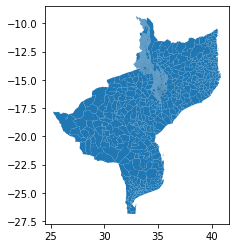

In [13]:
polys.plot()

In [14]:
# Dissolve 
polys['ID'] = 'M-M-Z'
diss = polys.dissolve(by = 'ID')

<AxesSubplot:>

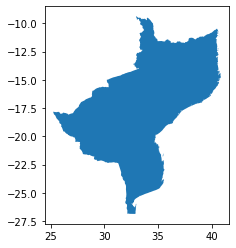

In [15]:
diss.plot()

In [16]:
# write
diss.to_file(DATA_PATH+'interim/M-M-Z-0.shp')

### Admin 2/3 - from GPWv4 documentation
- Zimbabwe is admin 2, Moz is admin 3, & Mal is admin 3

In [3]:
# polys in
zwe = gpd.read_file(DATA_PATH+'raw/GPWv4-boundaries/gwpv4_zwe_admin2.shp')[['geometry','ISOALPHA','UBID', 'AREAKM']]
mwi = gpd.read_file(DATA_PATH+'raw/GPWv4-boundaries/gwpv4_mwi_admin3.shp')[['geometry','ISOALPHA','UBID', 'AREAKM']]
moz = gpd.read_file(DATA_PATH+'raw/GPWv4-boundaries/gwpv4_moz_admin3.shp')[['geometry','ISOALPHA','UBID', 'AREAKM']]

In [4]:
dfs = [zwe, mwi, moz]
polys = gpd.GeoDataFrame(pd.concat(dfs))

,geometry,ISOALPHA,UBID,AREAKM
0,"POLYGON ((31.85267 -17.44063, 31.86651 -17.459...",ZWE,253_5_21,3500.742518
1,"POLYGON ((31.00820 -21.00644, 31.01552 -21.011...",ZWE,253_7_37,12919.535287
2,"POLYGON ((32.71144 -16.60204, 32.71171 -16.602...",ZWE,253_4_15,2332.567032
3,"POLYGON ((31.43809 -16.15538, 31.43825 -16.160...",ZWE,253_4_11,4290.956612
4,"POLYGON ((31.94368 -16.41998, 31.95605 -16.422...",ZWE,253_4_14,4525.440142


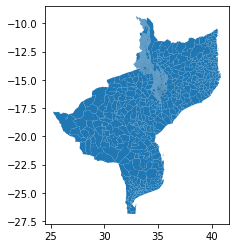

In [5]:
polys.plot()
polys.head()

In [6]:
# write
polys.to_file(DATA_PATH+'interim/M3-M3-Z2.shp')

## Drop Galapagos Islands for Ecuador

In [38]:
# polys in
ecu = gpd.read_file(DATA_PATH+'raw/GPWv4-boundaries/gwpv4_ecu_admin3.shp')
fn_out = DATA_PATH+'interim/ECU-clip0.shp'

<AxesSubplot:>

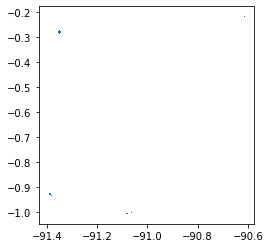

In [50]:
ecu[ecu['OBJECTID'] == 993].plot()

<AxesSubplot:>

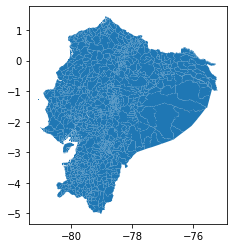

In [53]:
# dissolve floods and get bounding box
ecu_mainland = ecu[ecu['NAME1'] != 'Galapagos']
ecu_mainland = ecu_mainland[ecu_mainland['OBJECTID'] != 993] # tiny islands near Galapagos 
ecu_mainland.plot()

In [54]:
# gwpv4 admin 3 clipped out 
fn_out = DATA_PATH+'/interim/ECU-clip3.shp'
ecu_mainland.to_file(fn_out)

In [55]:
# diss gwpv4 ecu for admin 0
diss = ecu_mainland.dissolve(by = 'ISOALPHA')
fn_out = DATA_PATH+'interim/ECU-clip0.shp'
diss.to_file(fn_out)

## Turn GDAM polygons into raster bianaries

**NOTE : Don't think we need this 2021.03.03 CPT** <br>


In [47]:
def poly_to_raster (rst, polys, value, touched, out_fn, fill_value):
    """Function makes a raster from a list of polygons
    
    Args:   rst = input raster already read in as a rasterio object to act as a template
            polys = input polygons already read in as a gpd dataframe
            value = col with value to burn into raster
            touched = bool, if True all pixels touched (not centers) are burned into raster
            out_fn = out file name 
            fill_value = value to revalue input raster before burning in polygons 
    
    """

    meta = rst.meta.copy() # copy meta data from rst
    out_arr = rst.read(1) # get an array to burn shapes
    out_arr.fill(fill_value) # revalue rst to an Nan Value before burning in polygons
    
    # extract geom and values to burn
    shapes = ((geom,value) for geom, value in zip(polys['geometry'], polys[value])) 
    
    # burn shapes intp an array
    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=rst.transform, all_touched=touched)
    
    # write our raster to disk
    with rasterio.open(out_fn, 'w', **meta) as out:
        out.write_band(1, burned)

In [48]:
def raster_clip(rst_in, polys, rst_out):
    
    """ function clips a raster and saves it out
    args:
        rst_in = raster you want to clip
        polys = polys you want to clip to
        rst_out = name of clipped raster
    """
    
    # clip raster
    with rasterio.open(rst_in) as src:
        out_image, out_transform = rasterio.mask.mask(src, polys, crop=True, nodata = 0)
        out_meta = src.meta
        
    # Update meta data
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
    # write image 
    with rasterio.open(fn_out, "w", **out_meta) as dest:
        dest.write(out_image)

In [49]:
def burn_rst(polys_fn, fn_out):
    
    # open polys
    polys = gpd.read_file(polys_fn)

    # update columns
    polys = polys[['geometry']]
    polys['value'] = 1
    
    # open GPWv4 as template
    rst = rasterio.open(DATA_PATH+'raw/gpw_v4/gpw-v4-population-count-rev11_2015_30_sec_tif/gpw_v4_population_count_rev11_2015_30_sec.tif')
    
    # set args
    value = 'value'
    touched = False # see rasterio documentation, using un-touched in this analysis 
    fill_value = 0
    
    # burn rst
    poly_to_raster(rst, polys, value, touched, fn_out, fill_value)
    
    # Now clip the raster
    rst_fn = fn_out
    rst_out = fn_out
    polys = polys['geometry']

    raster_clip(rst_fn, polys, rst_out)
    
    print(fn_out, 'done')

In [50]:
# Nepal
polys_fn = DATA_PATH+'raw/GPWv4-boundaries/gwpv4_npl_admin4.shp'
fn_out = DATA_PATH+'interim/NPL-rst.tif'
burn_rst(polys_fn, fn_out)

/Users/cascade/Github/PopGridCompare/data/interim/NPL-rst.tif done


In [51]:
# MMZ
polys_fn = DATA_PATH+'interim/M-M-Z-0.shp'
fn_out = DATA_PATH+'interim/MMZ-rst.tif'
burn_rst(polys_fn, fn_out)

/Users/cascade/Github/PopGridCompare/data/interim/MMZ-rst.tif done


In [52]:
# ECU
polys_fn = DATA_PATH+'interim/ECU-clip0.shp'
fn_out = DATA_PATH+'interim/ECU-rst.tif'
burn_rst(polys_fn, fn_out)

/Users/cascade/Github/PopGridCompare/data/interim/ECU-rst.tif done


## Idai Flood Raster
Data from human data exchange, at 30m resolution values = 1 & 255 <br>
Need to resample with a majority filter at 1-km

**NOTE** USING FLOOD RASTER GREG MADE WITH ARCPY 2021.02.03 CPT

In [ ]:
# def resample(fn_in, fn_out, scale_factor, method):
    
#     """ Resamples a raster and save it out
#     Args:
#         fn_in = file path and name of tif input as str
#         fn_out = file path and name of tif output as str 
#         scale_factor = factor to up or down scale a pixel as float
#         method = method to resample (rasterio object), see rasterio documentation
#     """
    
#     with rasterio.open(fn_in) as dataset:

#         # resample data to target shape
#         data = dataset.read(
#             out_shape=(
#                 dataset.count,
#                 int(dataset.height * scale_factor),
#                 int(dataset.width * scale_factor)
#             ),
#             resampling=method
#         )

#         # scale image transform
#         transform = dataset.transform * dataset.transform.scale(
#             (dataset.width / data.shape[-1]),
#             (dataset.height / data.shape[-2])
#         )
    
#     # meta data to write out
#     out_meta = dataset.meta

#     # Update meta data
#     out_meta.update({"driver": "GTiff",
#              "height": data.shape[1],
#              "width": data.shape[2],
#              "transform": transform})

#     # write image 
#     with rasterio.open(fn_out, "w", **out_meta) as dest:
#         dest.write(data)

In [ ]:
# # Resample
# rst_fn = data_in+'Idai/HDX/moz_totalfloodextent/MOZ_TotalFloodExtent12to2.tif'
# fn_out = data_out+'Idai_flood1km.tif'

In [ ]:
# resample(fn_in, fn_out, 1/10, Resampling.mode) ... 
# flood pixels are 90m so 1/10 will make 1-km
# resample(rst_fn, fn_out, 1/11, Resampling.mode)

In [ ]:
# # Reproject all datasets to GPWv4

# # files
# rst_fn = data_out+'Idai_flood1km.tif'
# mmz_fn = data_out+'M-M-Z-rst.tif'
# rst_out = data_out+'Idai_flood1km-matched.tif'

# # open & reproject
# rst = rio.open_rasterio(rst_fn)
# mmz = rio.open_rasterio(mmz_fn)
# match = rst.rio.reproject_match(mmz)

# # fix fill value
# match.data = np.where(match.data == 255, 0, match.data)
# match.data = match.data.astype('int8')
# match.attrs['_FillValue'] = -99
# match.rio.to_raster(rst_out)

In [ ]:
# # re-set values
# rst_fn = data_in+'Idai/HDX/moz_totalfloodextent/MOZ_TotalFloodExtent12to2.tif'
# fn_out = data_out+'Idai_90m_zeros.tif'
# rst = rasterio.open(rst_fn)
# arr = rst.read(1)
# arr_out = np.where(arr == 255, 0, arr)

# out_metta = rst.meta
# with rasterio.open(fn_out, "w", **out_meta) as dest:
#     dest.write(arr_out, 1)

# print(rasterio.open(fn_out).meta)
# print(np.unique(rasterio.open(fn_out).read(1)))

In [ ]:
# # Majority filter 

# rst_fn = data_out+'Idai_90m_zeros.tif'
# fn_out = data_out+'Idai_flood-majority.tif'

# wbt = WhiteboxTools()
# wbt.majority_filter(rst_fn, fn_out, filterx=11, filtery=11)